In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score


In [2]:
df = pd.read_csv('../Data/address_data_combined.csv')
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342


In [3]:
X = df.drop(columns=['Address','FLAG'])
y = df['FLAG']
print(X.shape)
print(y.shape)

(12397, 12)
(12397,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3,stratify=y)

print(X_train.shape)
print(X_test.shape)

(8677, 12)
(3720, 12)


In [5]:
import numpy as np

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
  X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.isnan(X_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
tuned_parameters = [
    { "gamma": [1,0.1,0.01,0.001], "C": [1, 10, 100, 1000]},
]

grid = GridSearchCV(SVC(kernel='linear'),tuned_parameters, refit=True,verbose=2,cv=5, scoring='f1')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................................C=1, gamma=1; total time=   0.6s
[CV] END .......................................C=1, gamma=1; total time=   0.5s
[CV] END .......................................C=1, gamma=1; total time=   0.6s
[CV] END .......................................C=1, gamma=1; total time=   0.5s
[CV] END .......................................C=1, gamma=1; total time=   0.5s
[CV] END .....................................C=1, gamma=0.1; total time=   0.5s
[CV] END .....................................C=1, gamma=0.1; total time=   0.5s
[CV] END .....................................C=1, gamma=0.1; total time=   0.5s
[CV] END .....................................C=1, gamma=0.1; total time=   0.5s
[CV] END .....................................C=1, gamma=0.1; total time=   0.5s
[CV] END ....................................C=1, gamma=0.01; total time=   0.5s
[CV] END ....................................C=1

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001]}],
             scoring='f1', verbose=2)

In [7]:
grid.best_params_

{'C': 1000, 'gamma': 1}

In [8]:
grid.best_score_

0.8426590525461274

In [9]:
from sklearn.metrics import accuracy_score
predicted_y_acc = grid.predict(X_test)
predicted_y_acc = (predicted_y_acc > 0.5).astype('int32')
accuracy_score(predicted_y_acc, y_test)

0.8911290322580645

In [14]:
print("Tuned Hyperparameters :", grid.best_params_)
print("Train F1 Score :",grid.best_score_)
best_y_pr = grid.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 1000, 'gamma': 1}
Train F1 Score : 0.8426590525461274
Test F1 Score:  0.8512669849430775


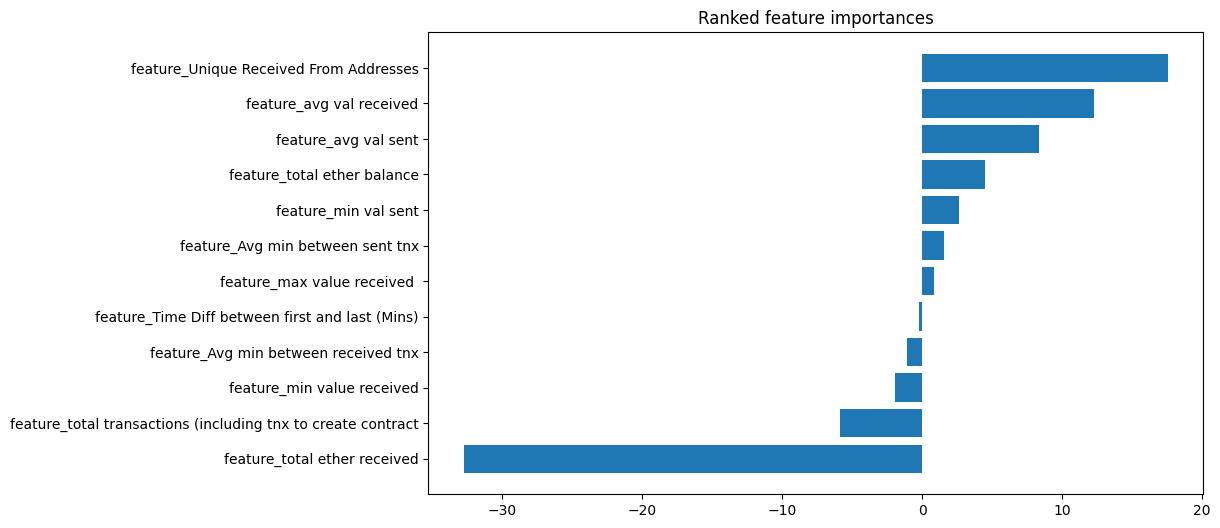

In [10]:
from matplotlib import pyplot as plt
feat_importances = grid.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();